##### https://www.kaggle.com/code/imegirin/multivariate-time-series-modeling-with-pytorch
##### https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_10_2_lstm.ipynb
##### https://github.com/curiousily/Getting-Things-Done-with-Pytorch
##### https://www.kaggle.com/code/megner/pytorch-lightning-lstm

Following is an example how one can rewrite pytorch LSTM model in a Lightning form. The goal is to create 'trainer' instance from Trainer class of pytorch lightning. A Trainer consists of System part and DataModule part. System part consists of Model part (including forward method) and training part (including loss function, optimizer etc.). DataModule consists of Dataloader for training, validation and test dataset. The datasets are defined by pytorch Dataset class. In short, the relations between each class are
```
Trainer --+-- System -----+- Model (network definition and forward method)
          |               | 
          |               +- training scheme (optimizer, loss function etc.)
          | 
          +-- Data Module -- Dataloader
                             +-- DataSet
```

In the example below, the components are named as follows.

IndoorDataset3    : Dataset
IndoorLSTM       : Model 
IndoorDataModule : DataModule
IndoorSystem     : System to feed to trainer (includes training system inside)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger

In [2]:
class MultiVariableDataset(Dataset):
    def __init__(self, df_raw, features, target, seq_len):
        self.data = df_raw
        self.seq_len = seq_len
        self.y = torch.tensor(self.data[target].values).float()
        # self.y = torch.tensor(self.data[target].values).float()
        self.X = torch.tensor(self.data[features].values).float()

    def __len__(self):
        return self.data.shape[0] - self.seq_len -1

    def __getitem__(self, idx):
        features = self.X[idx:(idx + self.seq_len)]
        target = self.y[idx + self.seq_len]  # the return value is numpy float
        target = target.unsqueeze(0)
       
        return features, target

In [3]:
class PassengerDataModule(pl.LightningDataModule):
    '''
    PyTorch Lighting DataModule subclass:
    https://pytorch-lightning.readthedocs.io/en/latest/datamodules.html

    Serves the purpose of aggregating all data loading 
      and processing work in one place.
    '''
    
    def __init__(self, seq_len = 1, batch_size = 128, num_workers=0):
        super().__init__()
        self.raw_df = None
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_size = None #int(len(df_final) * 0.66)
        self.valid_size = None #len(df_final) - train_size
        
        self.features = ['year', 'month', '#Passengers']
        self.target = '#Passengers'
        
    def prepare_data(self):
        pass

    def setup(self, stage=None):

        if stage == 'fit' and self.raw_df is not None:
            return 
        if stage == 'test' and self.raw_df is not None:
            return
        if stage is None and self.raw_df is not None:  
            return

        dataframe = pd.read_csv('archive/AirPassengers.csv', parse_dates=['Month'])
        dataframe = dataframe.sort_values(by='Month').reset_index(drop=True)
        dataframe['year'] = dataframe['Month'].dt.year
        dataframe['month'] = dataframe['Month'].dt.month
        
        # nomalization
        # df_values = dataframe['#Passengers']
        # min_value = df_values.min()
        # max_value = df_values.max()
        
        # df_norm = (df_values - min_value) / (max_value - min_value)
        # df_final = pd.concat([df_norm, dataframe[['year', 'month']]], axis=1)

        # Normalization is optional but recommended for neural network as certain 
        # activation functions are sensitive to magnitude of numbers. 
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
        dataset = scaler.fit_transform(raw_data)

        
        self.raw_df = df_final
        self.train_size = int(len(df_final) * 0.66)
        self.valid_size = len(df_final) - self.train_size
        print('setup is finished')
        
    def train_dataloader(self):
        train_dataset = MultiVariableDataset(self.raw_df.loc[0:self.train_size,:], self.features, self.target, self.seq_len)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False,num_workers=self.num_workers)
        return train_loader

    def val_dataloader(self):
        val_dataset = MultiVariableDataset(self.raw_df.loc[self.train_size:,:], self.features, self.target, self.seq_len)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        return val_loader
    # for now the test dataloader is the same as the valid dataloader
    def test_dataloader(self):
        test_dataset = MultiVariableDataset(self.raw_df.loc[self.train_size:,:], self.features, self.target, self.seq_len)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        return test_loader

In [4]:
aa = PassengerDataModule(4, 4, 0)
aa.setup()
temp_dataloader = aa.val_dataloader()
print(len(temp_dataloader))
dataiter = iter(temp_dataloader)
inputs, target = next(dataiter)
print(inputs[:,:,1])
print(target[:,0])

setup is finished
11
tensor([[12.,  1.,  2.,  3.],
        [ 1.,  2.,  3.,  4.],
        [ 2.,  3.,  4.,  5.],
        [ 3.,  4.,  5.,  6.]])
tensor([0.4710, 0.4846, 0.6139, 0.6969])


In [5]:
class LSTMRegressor(pl.LightningModule):

    def __init__(self, 
                 n_features, 
                 hidden_size, 
                 seq_len, 
                 batch_size,
                 num_layers, 
                 dropout
                 ):
        super(LSTMRegressor, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(input_size=n_features, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            dropout=dropout, 
                            batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # lstm_out = (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:,-1])
        return y_pred
    
    

In [6]:
model = LSTMRegressor(3, 64, 4, 4, 2, 0.2)
model(inputs)

tensor([[0.1190],
        [0.1274],
        [0.1532],
        [0.1357]], grad_fn=<AddmmBackward0>)

In [7]:
class TrainingSteps(pl.LightningModule):

    def __init__(self, model=None):
        super().__init__()
        self.model = model
        self.learning_rate = 0.001
        self.criterion = nn.MSELoss()
    # --------------------------------------------
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.model.parameters(), lr=self.learning_rate, weight_decay=1e-2)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        log = {'train_loss': loss}
        return {'loss': loss, 'log': log}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        log = {'val_loss': loss}
        return {'val_loss': loss, 'log': log}
      
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        test_loss = self.criterion(y_hat, y)
        # result = pl.EvalResult()
        # result.log('test_loss', loss)
        return {'loss':test_loss}

In [8]:
training_steps = TrainingSteps(model)

In [10]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pathlib import Path

log_path = Path('.')
MODEL = log_path/'model_v1'
MODEL.mkdir(exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=MODEL,
    filename='m-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min'
)

trainer = Trainer(
    # gpus=0,
    max_epochs=100,
    logger=False,
    callbacks=[checkpoint_callback],
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
dm = PassengerDataModule(4, 4, 0)
training_steps = TrainingSteps(model)
trainer.fit(training_steps, dm)

C:\tools\WPy64-31180\python-3.11.8.amd64\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\temp\python_play_ground\sensor\model_v1 exists and is not empty.

  | Name      | Type          | Params
--------------------------------------------
0 | model     | LSTMRegressor | 51.0 K
1 | criterion | MSELoss       | 0     
--------------------------------------------
51.0 K    Trainable params
0         Non-trainable params
51.0 K    Total params
0.204     Total estimated model params size (MB)


setup is finished


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\tools\WPy64-31180\python-3.11.8.amd64\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\tools\WPy64-31180\python-3.11.8.amd64\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


In [13]:
def predict(dataloader, model):
    model.eval()
    preds = []
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            outputs = model(inputs)
            pred = outputs.detach().cpu().numpy()  # .squeeze()
            preds.append(pred)

        preds = np.array(preds)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        return preds


results = predict(dm.val_dataloader(), model)

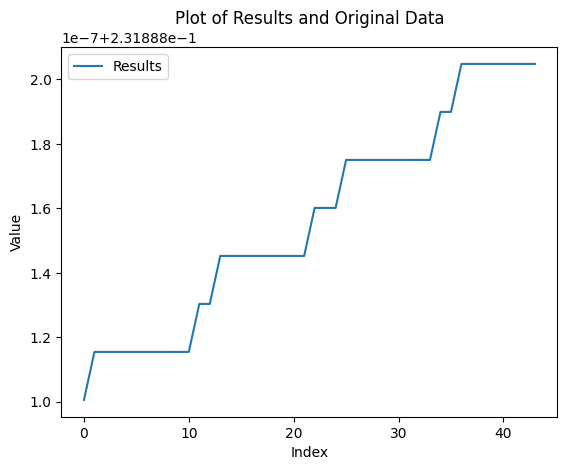

In [15]:

results_1d= results.flatten()
plt.plot(results_1d, label='Results')
# plt.plot(original_data_1d[4:48], label='Original Data')
plt.title('Plot of Results and Original Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
class PassengerSystem(pl.LightningModule):

    def __init__(self, model=None, fold=0, LR=0.1, LR2=1e-4, EP=16, LOG=None):
        super().__init__()

        self.model = model
        self.fold = fold
        self.best_score = 1000
        self.best_loss = 1000 * 1000
        self.best_epoch = -1
        self.learning_rate = LR
        self.LR1 = LR
        self.LR2 = LR2
        self.EP = EP

        self.ff = LOG
        self.criterion = nn.MSELoss()
    # --------------------------------------------
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.model.parameters(), lr=self.learning_rate, weight_decay=1e-2)
        
        gamma = (self.LR2/self.LR1) ** (1.0 / self.EP)

        scheduler = {'scheduler': torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=gamma),
                     'interval': 'epoch'}

        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        result = pl.TrainResult(loss)
        result.log('train_loss', loss)
        return result

    def training_epoch_end(self, outputs):
        opt = self.optimizers()
        self.learning_rate = opt.param_groups[0]['lr']
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        result = pl.EvalResult(checkpoint_on=loss)
        result.log('val_loss', loss)
        return result
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        result = pl.EvalResult()
        result.log('test_loss', loss)
        return result
        
    def validation_epoch_end(self, outputs):
        loss = torch.stack([f['loss'] for f in outputs]).mean()         
        self.log('val_loss', loss)


In [ ]:
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler


# scaler = MinMaxScaler()

# dfTest = pd.DataFrame({'A':[14.00,90.20,90.95,96.27,91.21],
#                            'B':[103.02,107.26,110.35,114.23,114.68],
#                            'C':['big','small','big','small','small']})

# dfTest[['A', 'B']] = scaler.fit_transform(dfTest[['A', 'B']])

# dfTest = pd.DataFrame({'A':[14.00,90.20,90.95,96.27,91.21],'B':[103.02,107.26,110.35,114.23,114.68], 'C':['big','small','big','small','small']})
# df = dfTest[['A', 'B']]
# df_norm = (df - df.min()) / (df.max() - df.min())
# print df_norm
# print pd.concat((df_norm, dfTest.C),1)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim



In [ ]:
# load the dataset
dataframe = pd.read_csv('archive/AirPassengers.csv', parse_dates=['Month'])
dataframe = dataframe.sort_values(by='Month').reset_index(drop=True)
dataframe['year'] = dataframe['Month'].dt.year
dataframe['month'] = dataframe['Month'].dt.month
dataframe.head()

In [ ]:
# nomalization
df_values = dataframe['#Passengers']
min_value = df_values.min()
max_value = df_values.max()

df_norm = (df_values - min_value) / (max_value - min_value)
df_norm.head()
df_final = pd.concat([df_norm, dataframe[['year', 'month']]], axis=1)
df_final.head()

In [ ]:
# Create data loader
dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False)
# Get one batch of data
dataiter = iter(dataloader)
inputs, target = next(dataiter)
print(inputs[:,:,1])
print(target[:,0])
